Notebook da competição do Kaggle House Prices: Advanced Regression Techniques
(https://www.kaggle.com/c/house-prices-advanced-regression-techniques)

Melhor score: 0.14229, posição 2183

- Primeira submissão: todas as variáveis presentes
- Segunda submissão: deixei apenas as variáveis cujas importâncias (obtidas a partir da primeira submissão) eram maiores que 0.3; o resultado foi pior do que o inicial
- Terceira submissão: voltei todas as variáveis; modificação no número de estimators (2500) e no max_features (0.5); subi 129 posições (score 0.14546 -> 0.14229)

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics

In [3]:
PATH = "data/"

In [4]:
!ls {PATH}

sample_submission.csv  test.csv  train.csv


In [4]:
df_train = pd.read_csv(f'{PATH}/train.csv')
df_test = pd.read_csv(f'{PATH}/test.csv')

In [6]:
df_train.shape, df_test.shape

((1460, 81), (1459, 80))

In [5]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [7]:
display_all(df_train.T)

In [8]:
display_all(df_train.describe(include='all').T)

In [9]:
display_all(df_test.describe(include='all').T)

In [6]:
#concatenando os sets para facilitar o pré-processamento
df_all = df_train.append(df_test, sort= False)
df_all.shape

(2919, 81)

A métrica sugerida pelo Kaggle é a RMLSE (root mean squared log error) entre o valor de venda previsto e atual. Logo, para facilitar, substituimos a variável alvo (dependente) - SalePrice - pelo seu log.

In [7]:
df_all.SalePrice = np.log(df_all.SalePrice)

In [8]:
(df_train.isnull().sum()/len(df_train)).sort_values(ascending=False)

In [9]:
(df_test.isnull().sum()/len(df_test)).sort_values(ascending=False)

In [20]:
cols_with_high_null = []
for col in df_all.columns.tolist():
    if df_all[col].isnull().sum()/len(df_all) > 0.90:
        cols_with_high_null.append(col)
cols_with_high_null

['Alley', 'PoolQC', 'MiscFeature']

As seguintes features contém muitos valores inexistentes, tanto no set de treino como no set de test:

- Alley: tipo de acesso ao jardim (cascalho, pavimentado)
- PoolQC: qualidade da piscina
- MiscFeature: outras características não disponíveis em outras categorias (elevador, segunda garagem, quadra de tênis)
- Fence: qualidade da cerca

Os 2 últimos, aparentemente, podem influenciar mais fortemente no preço da casa. O primeiro, inicialmente, acredito que não.

Nota: após a primeira execução, a listagem de features importantes mostrou que essas colunas não influenciam no resultado. Nesta segunda vez, vou removê-las - além de outras que não afetam o resultado.

Na listagem de importância, essas foram as features que mais contribuíram para o resultado:

- Variable: OverallQual          Importance: 0.25
- Variable: GrLivArea            Importance: 0.13
- Variable: GarageCars           Importance: 0.1
- Variable: ExterQual            Importance: 0.09
- Variable: TotalBsmtSF          Importance: 0.05
- Variable: YearBuilt            Importance: 0.04
- Variable: KitchenQual          Importance: 0.04
- Variable: 1stFlrSF             Importance: 0.03
- Variable: 2ndFlrSF             Importance: 0.03
- Variable: GarageArea           Importance: 0.03


Vou dropar todas as que não estão listadas acima.

In [18]:
#important_cols = ['OverallQual', 'GrLivArea', 'GarageCars', 'ExternQual', 'TotalBsmtSF', 'YearBuilt', 'KitchenQual', '1stFlrSF', '2ndFlrSF', 'GarageArea', 'SalePrice']
#cols_drop = [col for col in df_all.columns.tolist() if col not in important_cols]

In [21]:
# vou dropar as colunas com alto índice de nulos
df_all.drop(columns=cols_with_high_null, inplace=True)

In [9]:
df_all.sample(10)

,OverallQual,YearBuilt,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,KitchenQual,GarageCars,GarageArea,SalePrice
980,7,1961,944.0,999,0,999,Ex,2.0,588.0,178400.0
1131,5,1991,974.0,974,0,974,TA,0.0,0.0,93500.0
144,8,1998,1049.0,1036,880,1916,Gd,3.0,741.0,NaN
1066,6,1993,799.0,799,772,1571,TA,2.0,380.0,178000.0
119,6,2005,728.0,728,728,1456,Gd,2.0,390.0,163990.0
1049,8,2006,1489.0,1500,0,1500,Gd,2.0,674.0,NaN
662,6,1968,1392.0,1392,0,1392,TA,2.0,576.0,110000.0
1389,8,1999,1090.0,1090,1124,2214,Gd,3.0,646.0,NaN
1226,6,2007,894.0,894,1039,1933,Gd,3.0,668.0,214000.0
1117,5,1922,816.0,816,0,816,TA,1.0,100.0,NaN


In [22]:
# descoberta de colunas que não tem valor numéricos; devem ser categorizadas
columns_not_numeric = [column for column in df_all.columns.tolist() if column not in df_all._get_numeric_data().columns.tolist()]
columns_not_numeric

['MSZoning',
 'Street',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'Fence',
 'SaleType',
 'SaleCondition']

In [23]:
train_cats(df_all)

As variáveis categóricas acima estão fora de uma ordem natural. Vamos ordená-las.

Ordenação baseada na descrição disponível em https://storage.googleapis.com/kaggle-competitions-data/kaggle/5407/data_description.txt?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1532350002&Signature=WEhsZeEBZXj9X40gvQ%2BbvvtbDWygObtCJzlxjyoHfhBWz4o%2FxYPOvXHbviknMHCMquH5vVQSivCjjAfOG9lxM0PGrFGWzjF3Zdj%2Bq5lRc7iK29sZ02Fr7LONmoYtZMHeEaFKmTCmrVN0QvSEqsWcA5bBZXE6tIAHZP9rAaWF80PUF6DzPpHKMM4SRkTlvXjCXrsq5uOWbu0XOTfrz9%2F3qtU78a7j9G0n0xetfjE2t9YFA7h5Us6ylxUqCElzjiRH4lkjpyQMMbI%2BCtm6FgU5WA8qLdiyzc%2BShwYAKYTCcQyDr8H4L6tbYiUaUFpFXLLmEK5wnd5h3RkwRmb6J3ZVVw%3D%3D

In [24]:
df_all.ExterQual.cat.set_categories(['Ex', 'Gd', 'TA', 'Fa', 'Po'], ordered=True, inplace = True)
df_all.ExterCond.cat.set_categories(['Ex', 'Gd', 'TA', 'Fa', 'Po'], ordered=True, inplace = True)
df_all.BsmtQual.cat.set_categories(['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'], ordered=True, inplace = True)
df_all.BsmtCond.cat.set_categories(['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'], ordered=True, inplace = True)
df_all.BsmtExposure.cat.set_categories(['Gd', 'Av', 'Mn', 'No', 'NA'], ordered=True, inplace = True)
df_all.BsmtFinType1.cat.set_categories(['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ', 'Unf', 'NA'], ordered=True, inplace = True)
df_all.BsmtFinType2.cat.set_categories(['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ', 'Unf', 'NA'], ordered=True, inplace = True)
df_all.HeatingQC.cat.set_categories(['Ex', 'Gd', 'TA', 'Fa', 'Po'], ordered=True, inplace = True)
df_all.KitchenQual.cat.set_categories(['Ex', 'Gd', 'TA', 'Fa', 'Po'], ordered=True, inplace = True)
df_all.FireplaceQu.cat.set_categories(['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'], ordered=True, inplace = True)
df_all.GarageFinish.cat.set_categories(['Fin', 'RFn', 'Un', 'NA'], ordered=True, inplace = True)
df_all.GarageQual.cat.set_categories(['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'], ordered=True, inplace = True)
df_all.GarageCond.cat.set_categories(['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'], ordered=True, inplace = True)
#df_all.PoolQC.cat.set_categories(['Ex', 'Gd', 'TA', 'Fa', 'NA'], ordered=True, inplace = True) foi dropada

Atribuindo valores numéricos às variáveis categóricas.

In [25]:
for column in columns_not_numeric:
    df_all[column] = df_all[column].cat.codes

In [26]:
display_all(df_all.head(15).T)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Id,1.000000,2.000000,3.000000,4.000000,5.000000,6.0000,7.000000,8.000000,9.00000,10.00000,11.000000,12.0000,13.000000,14.000000,15.000000
MSSubClass,60.000000,20.000000,60.000000,70.000000,60.000000,50.0000,20.000000,60.000000,50.00000,190.00000,20.000000,60.0000,20.000000,20.000000,20.000000
MSZoning,3.000000,3.000000,3.000000,3.000000,3.000000,3.0000,3.000000,3.000000,4.00000,3.00000,3.000000,3.0000,3.000000,3.000000,3.000000
LotFrontage,65.000000,80.000000,68.000000,60.000000,84.000000,85.0000,75.000000,NaN,51.00000,50.00000,70.000000,85.0000,NaN,91.000000,NaN
LotArea,8450.000000,9600.000000,11250.000000,9550.000000,14260.000000,14115.0000,10084.000000,10382.000000,6120.00000,7420.00000,11200.000000,11924.0000,12968.000000,10652.000000,10920.000000
Street,1.000000,1.000000,1.000000,1.000000,1.000000,1.0000,1.000000,1.000000,1.00000,1.00000,1.000000,1.0000,1.000000,1.000000,1.000000
LotShape,3.000000,3.000000,0.000000,0.000000,0.000000,0.0000,3.000000,0.000000,3.00000,3.00000,3.000000,0.0000,1.000000,0.000000,0.000000
LandContour,3.000000,3.000000,3.000000,3.000000,3.000000,3.0000,3.000000,3.000000,3.00000,3.00000,3.000000,3.0000,3.000000,3.000000,3.000000
Utilities,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.00000,0.00000,0.000000,0.0000,0.000000,0.000000,0.000000
LotConfig,4.000000,2.000000,4.000000,0.000000,2.000000,4.0000,4.000000,0.000000,4.00000,0.00000,4.000000,4.0000,4.000000,4.000000,0.000000


Vamos ver a correlação entre as features e a variável dependente (SalePrice).

In [60]:
corr = df_train.corr()
corr_price = corr['SalePrice'].to_dict()
corr_price
del corr_price['SalePrice']
for ele in sorted(corr_price.items(), key = lambda x: -abs(x[1])):
    print("{0}: \t{1}".format(*ele))

OverallQual: 	0.7909816005838047
GrLivArea: 	0.7086244776126511
GarageCars: 	0.640409197258349
GarageArea: 	0.6234314389183598
TotalBsmtSF: 	0.6135805515591944
1stFlrSF: 	0.6058521846919166
FullBath: 	0.5606637627484452
TotRmsAbvGrd: 	0.5337231555820238
YearBuilt: 	0.5228973328794967
YearRemodAdd: 	0.5071009671113867
GarageYrBlt: 	0.48636167748786213
MasVnrArea: 	0.4774930470957107
Fireplaces: 	0.4669288367515242
BsmtFinSF1: 	0.38641980624215627
LotFrontage: 	0.35179909657067854
WoodDeckSF: 	0.32441344456813076
2ndFlrSF: 	0.31933380283206614
OpenPorchSF: 	0.31585622711605577
HalfBath: 	0.2841076755947784
LotArea: 	0.2638433538714063
BsmtFullBath: 	0.22712223313149718
BsmtUnfSF: 	0.214479105546969
BedroomAbvGr: 	0.1682131543007415
KitchenAbvGr: 	-0.1359073708421417
EnclosedPorch: 	-0.12857795792595636
ScreenPorch: 	0.11144657114291048
PoolArea: 	0.09240354949187278
MSSubClass: 	-0.08428413512659523
OverallCond: 	-0.0778558940486776
MoSold: 	0.04643224522381936
3SsnPorch: 	0.044583665335

In [71]:
cols_keep = [item[0] for item in corr_price.items() if item[1] > 0.0]
cols_keep.append('SalePrice')
cols_keep

['LotFrontage',
 'LotArea',
 'OverallQual',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'GrLivArea',
 'BsmtFullBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MoSold',
 'SalePrice']

In [75]:
drop = [col for col in df_all.columns.tolist() if col not in cols_keep]
df_all.drop(columns=drop, inplace=True)

In [76]:
# Separando novamente os sets de treino e test
df_test = df_all.iloc[1460:].copy()
df_train = df_all.iloc[:1460].copy()

In [77]:
df_train.shape,df_test.shape

((1460, 28), (1459, 28))

In [78]:
df, y, nas = proc_df(df_train, 'SalePrice')

In [100]:
display_all(df.sample(10).T)

,1237,643,982,1430,166,290,1420,961,1055,638
LotFrontage,41,80,43,60,69,120,90,69,104,67
LotArea,12393,10793,3182,21930,10708,15611,11700,12227,11361,8777
OverallQual,7,5,7,5,5,8,6,6,6,5
YearBuilt,2004,1969,2007,2005,1955,2006,1968,1977,1976,1910
YearRemodAdd,2005,1969,2007,2005,1993,2006,1968,1995,1976,1950
MasVnrArea,0,263,16,0,0,0,420,424,160,0
BsmtFinSF1,0,493,0,0,379,0,404,896,644,0
BsmtUnfSF,847,0,1266,732,470,1079,304,434,549,796
TotalBsmtSF,847,780,1266,732,1617,1079,708,1330,1193,796
1stFlrSF,847,780,1266,734,1867,1079,708,1542,1523,796


In [102]:
colsna_drop = ['LotFrontage_na', 'MasVnrArea_na', 'GarageYrBlt_na']
df.drop(columns=colsna_drop, inplace=True)

In [103]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df, y, test_size = 0.20, random_state = 42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1168, 27), (1168,), (292, 27), (292,))

In [104]:
m = RandomForestRegressor(n_jobs=-1, random_state=42)
m.fit(df,y)
m.score(df, y)

0.9717094851324306

In [105]:
#def mse(x,y):
#    return metrics.mean_squared_error(x,y)

#def rmse(x,y): return np.sqrt(mse(x,y))

#def print_score(m):
#    res = [rmse(np.log(y_train), np.log(m.predict(X_train))), rmse(np.log(y_test), np.log(m.predict(X_test)))]
#    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
#    print(res)
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_test), y_test),
                m.score(X_train, y_train), m.score(X_test, y_test)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [106]:
m = RandomForestRegressor(n_jobs=-1, random_state=42)
m.fit(df,y)
print_score(m)

[0.06523263916491848, 0.07438937175962806, 0.9720862324956872, 0.9703463142287412]


O valor acima já nos dá uma boa posição, aparentemente. Ainda temos um overfitting considerável.

Vamos melhorar os parâmetros.

In [91]:
# aumentando o número de árvores --> 360 parece ser o melhor
for n in range(250,262,1):
    m = RandomForestRegressor(n_jobs=-1, random_state=42, n_estimators=n, oob_score=True)
    m.fit(df,y)
    print(n, end =": ")
    print_score(m)
#360: [0.054591641317692216, 0.05638069073825081, 0.980450265602164, 0.9829659591761213, 0.8591985645050295]
#260: [0.05484031320264023, 0.05581507023708318, 0.9802717568967461, 0.9833060214778644, 0.8588392845880385]

250: [0.05488585072894154, 0.055870783457219894, 0.9802389799730982, 0.983272677813314, 0.8587303530913979]
251: [0.05490384862084823, 0.05582890204829573, 0.9802260179797878, 0.9832977464163245, 0.8586979735208755]
252: [0.05492619522418458, 0.055945549730853056, 0.980209918151834, 0.9832278788585421, 0.8586711256707917]
253: [0.05488717625021152, 0.05594148521611763, 0.9802380254841614, 0.9832303158015167, 0.8586967472695136]
254: [0.05489487415841587, 0.055911499340331156, 0.9802324818747444, 0.9832482888279767, 0.8586965512993148]
255: [0.05485471358730714, 0.055974195002286745, 0.9802613947535451, 0.983210699119921, 0.8586762626336244]
256: [0.05483818657978084, 0.05590863548268303, 0.9802732869288281, 0.9832500048716553, 0.8587907990763718]
257: [0.05481414872717344, 0.05586771609620147, 0.9802905772122129, 0.983274514455809, 0.8588665486926303]
258: [0.05478616965353381, 0.05586879146811685, 0.9803106928452845, 0.9832738705672888, 0.8589164936175363]
259: [0.05482273204229235, 0

In [84]:
# 2500 estimators nos parece ser o melhor resultado
m = RandomForestRegressor(n_jobs=-1, random_state=42, n_estimators=2500, oob_score=True)
m.fit(df,y)
print_score(m)
#[0.051337933099746505, 0.0526595482362543, 0.982711181406562, 0.9851402618283915, 0.8762967730234049]

[0.05457643588948096, 0.05757718707114474, 0.9804611544737021, 0.9822353037328099, 0.8593598249138038]


In [92]:
m = RandomForestRegressor(n_jobs=-1, random_state=42, n_estimators=360, oob_score=True)
m

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=360, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

In [29]:
?RandomForestRegressor

In [107]:
m = RandomForestRegressor(n_jobs=-1, random_state=42, n_estimators=360, oob_score=True, min_samples_leaf=1)
m.fit(df,y)
print_score(m)

[0.05468518288454689, 0.05674547635452336, 0.9803832121312517, 0.9827448240784771, 0.8583990298067434]


In [96]:
# entre 0.1 e 0.6 não melhorou
# entre 0.01 e 0.1 também não melhorou
n_estimators = 360# 2500
for msl in np.arange(0.1,0.6,0.1):
    m = RandomForestRegressor(n_jobs=-1, random_state=42, n_estimators=n_estimators, min_samples_leaf=msl, oob_score=True)
    m.fit(df,y)
    print(msl, end =": ")
    print_score(m)

0.1: [0.21438099402492578, 0.23202537473773255, 0.6985181867905927, 0.7115119256758751, 0.6886634040141654]
0.2: [0.2803708876506532, 0.2962779673515342, 0.48435074903579334, 0.5296126734969429, 0.49228428781991795]
0.30000000000000004: [0.3018651279601366, 0.33346628842470777, 0.40225706900134356, 0.40411730854334943, 0.39548654895379576]
0.4: [0.39049552794519804, 0.4327996575407841, -0.00027793113875818065, -0.0037619210339978615, -0.0014054792719859766]
0.5: [0.39049552794519793, 0.4327996575407841, -0.00027793113875818065, -0.0037619210339978615, -0.0014054792719859766]


Até agora, n_estimators = 2500 e min_samples_leaf = 1 (valor padrão) é a melhor combinação.

In [97]:
n_estimators = 360#2500
min_samples_leaf = 1

max_features = [0.3,0.35,0.4,0.45,0.5,'auto','log2','sqrt',None]
for mf in max_features:
    m = RandomForestRegressor(n_jobs=-1, random_state=42, n_estimators=n_estimators, min_samples_leaf=min_samples_leaf, max_features=mf, oob_score=True)
    m.fit(df,y)
    print(mf, end =": ")
    print_score(m)

0.3: [0.05301996675877138, 0.057548726181837914, 0.9815597221622994, 0.982252861870635, 0.8640810949868096]
0.35: [0.05271359714668115, 0.05707721052643122, 0.9817722163794973, 0.9825424867819548, 0.8659267232228047]
0.4: [0.052818015033822344, 0.057040102833225, 0.9816999317379099, 0.9825651787621148, 0.8654608285830883]
0.45: [0.05304845046973686, 0.0566034875292832, 0.9815399036424277, 0.982831068024656, 0.8650545573692234]
0.5: [0.05338704532112504, 0.05694195855305755, 0.9813034993294781, 0.9826251245124109, 0.8633895655561736]
auto: [0.05459164131769223, 0.05638069073825081, 0.980450265602164, 0.9829659591761213, 0.8591985645050295]
log2: [0.05315069187081511, 0.05761554810746761, 0.9814686780025266, 0.9822116242441007, 0.8635621991529124]
sqrt: [0.052916727373182475, 0.05751579738355308, 0.9816314653030951, 0.9822731655255996, 0.8648522434139051]
None: [0.054591641317692195, 0.056380690738250756, 0.980450265602164, 0.9829659591761213, 0.8591985645050295]


O valor <s>padrão de max_features</s> 0.5 é o que, aparentemente, traz o melhor resultado.

In [108]:
m = RandomForestRegressor(n_jobs=-1, random_state=42, n_estimators=360, min_samples_leaf=1, max_features=0.45, oob_score=True)
m.fit(df,y)
print_score(m)
#[0.04952836588630328, 0.05183804639169466, 0.9839084989963969, 0.985600276555861, 0.8845301083407711]

[0.05308149410512611, 0.05666922684836621, 0.9815168990619938, 0.9827911648537401, 0.8648339573018945]


In [32]:
m = RandomForestRegressor(n_jobs=-1, random_state=42, n_estimators=n_estimators, min_samples_leaf=min_samples_leaf, max_features=0.5, oob_score=True)
m

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.5, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=2500, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

Vamos fazer a busca randômica de hiperparâmetros para, apenas verificar, se há uma combinação melhor do que aquela descoberta até agora (n_estimators = 2500, min_samples_leaf = 1 e max_features = 0.5)

In [33]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in range(1000,3100,100)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt', 0.3, 0.35, 0.4, 0.45, 0.5]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 20]
# Minimum number of samples required at each leaf node
min_samples_leaf = np.arange(0.01, 0.5, 0.01).tolist()
min_samples_leaf.append(1)
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000], 'max_features': ['auto', 'sqrt', 0.3, 0.35, 0.4, 0.45, 0.5], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10, 20], 'min_samples_leaf': [0.01, 0.02, 0.03, 0.04, 0.05, 0.060000000000000005, 0.06999999999999999, 0.08, 0.09, 0.09999999999999999, 0.11, 0.12, 0.13, 0.14, 0.15000000000000002, 0.16, 0.17, 0.18000000000000002, 0.19, 0.2, 0.21000000000000002, 0.22, 0.23, 0.24000000000000002, 0.25, 0.26, 0.27, 0.28, 0.29000000000000004, 0.3, 0.31, 0.32, 0.33, 0.34, 0.35000000000000003, 0.36000000000000004, 0.37, 0.38, 0.39, 0.4, 0.41000000000000003, 0.42000000000000004, 0.43, 0.44, 0.45, 0.46, 0.47000000000000003, 0.48000000000000004, 0.49, 1], 'bootstrap': [True, False]}


In [32]:
#from sklearn.metrics import make_scorer

#def scorer(x,y):
#    return rmse(np.log(x), np.log(y))

#eval_scorer = make_scorer(score_func=scorer, greater_is_better=False)

In [37]:
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=1, random_state=42, n_jobs = -1, scoring='mean_squared_log_error')
# Fit the random search model
rf_random.fit(X_train, y_train)

ValueError: 'mean_squared_log_error' is not a valid scoring value. Valid options are ['accuracy', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision', 'completeness_score', 'explained_variance', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'fowlkes_mallows_score', 'homogeneity_score', 'mutual_info_score', 'neg_log_loss', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_median_absolute_error', 'normalized_mutual_info_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'r2', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'roc_auc', 'v_measure_score']

In [35]:
rf_random.best_params_

{'n_estimators': 1900,
 'min_samples_split': 20,
 'min_samples_leaf': 1,
 'max_features': 0.35,
 'max_depth': 60,
 'bootstrap': False}

In [39]:
m = RandomForestRegressor(n_jobs=-1, random_state=42, n_estimators=2500, min_samples_leaf=1, max_features=0.5, oob_score=True)
m.fit(df,y)
print_score(m)
# [0.04952836588630328, 0.05183804639169466, 0.9839084989963969, 0.985600276555861, 0.8845301083407711]

[0.04952836588630328, 0.05183804639169466, 0.9839084989963969, 0.985600276555861, 0.8845301083407711]


Para análise posteriores, vamos listar as features mais importantes.

In [72]:
?plt.axes

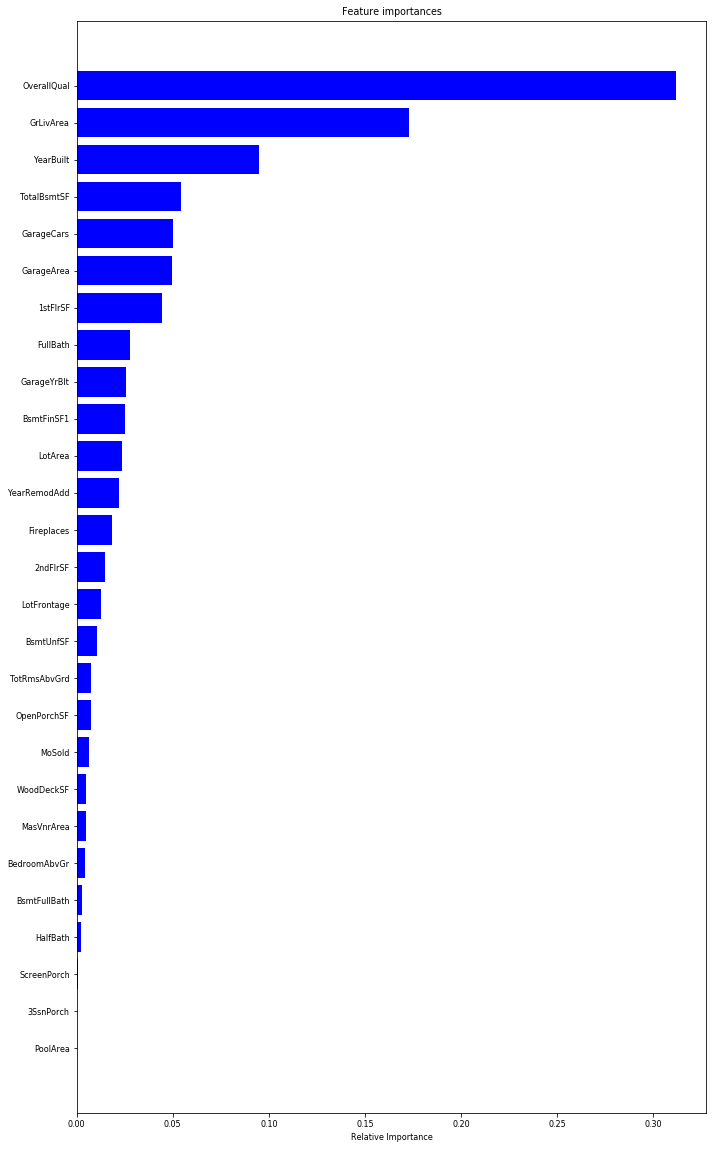

In [109]:
feature_list = list(df.columns)
# Get numerical feature importances
importances = list(m.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
#[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

indices = np.argsort(importances)

matplotlib.rcParams.update({'font.size': 8})
#plt.figure(figsize=(200,200))

plt.figure(figsize=(10,16))
plt.title("Feature importances")
plt.barh(range(len(indices)), m.feature_importances_[indices], color='b', align='center')
plt.yticks(range(len(indices)), [feature_list[i] for i in indices])
plt.xlabel('Relative Importance')
plt.tight_layout()
plt.show()

Do resultado anterior, confirmou-se a hipótese de que a variáveis com muitos valores nulos não contribuem para o resultado do modelo: Alley, PoolQC, MiscFeature e Fence.

In [89]:
df_test.sample(10).T

,559,1431,1350,371,889,576,1214,161,269,1038
Id,2020.0,2892.0,2811.0,1832.0,2350.0,2037.0,2675.0,1622.0,1730.0,2499.0
MSSubClass,190.0,30.0,20.0,90.0,60.0,160.0,120.0,50.0,90.0,30.0
MSZoning,3.0,0.0,3.0,4.0,1.0,1.0,3.0,3.0,3.0,3.0
LotFrontage,65.0,69.0,NaN,50.0,112.0,24.0,43.0,68.0,75.0,NaN
LotArea,8450.0,12366.0,9535.0,3000.0,12217.0,2645.0,3010.0,10544.0,8250.0,11515.0
Street,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Alley,-1.0,-1.0,-1.0,0.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0
LotShape,3.0,3.0,0.0,3.0,0.0,3.0,3.0,0.0,3.0,0.0
LandContour,3.0,3.0,3.0,0.0,3.0,3.0,3.0,3.0,3.0,3.0
Utilities,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [110]:
df, y, nas = proc_df(df_test, 'SalePrice')

In [111]:
display_all(df.T)

0      1      2      3      4      5      6      7     \
LotFrontage         80     81     74     78     43     75     67     63   
LotArea          11622  14267  13830   9978   5005  10000   7980   8402   
OverallQual          5      6      5      6      8      6      6      6   
YearBuilt         1961   1958   1997   1998   1992   1993   1992   1998   
YearRemodAdd      1961   1958   1998   1998   1992   1994   2007   1998   
MasVnrArea           0    108      0     20      0      0      0      0   
BsmtFinSF1         468    923    791    602    263      0    935      0   
BsmtUnfSF          270    406    137    324   1017    763    233    789   
TotalBsmtSF        882   1329    928    926   1280    763   1168    789   
1stFlrSF           896   1329    928    926   1280    763   1187    789   
2ndFlrSF             0      0    701    678      0    892      0    676   
GrLivArea          896   1329   1629   1604   1280   1655   1187   1465   
BsmtFullBath         0      0      0      0      0      0      1      0   
FullBath             1      1      2      2      2      2      2      2   
HalfBath             0      1      1      1      0      1      0      1   
BedroomAbvGr         2      3      3      3      2      3      3      3   
TotRmsAbvGrd         5      6      6      7      5      7      6      7   
Fireplaces           0      0      1      1      0      1      0      1   
GarageYrBlt       1961   1958   1997   1998   1992   1993   1992   1998   
GarageCars           1      1      2      2      2      2      2      2   
GarageArea         730    312    482    470    506    440    420    393   
WoodDeckSF         140    393    212    360      0    157    483      0   
OpenPorchSF          0     36     34     36     82     84     21     75   
3SsnPorch            0      0      0      0      0      0      0      0   
ScreenPorch        120      0      0      0    144      0      0      0   
PoolArea             0      0      0      0      0      0      0      0   
MoSold               6      6      3      6      1      4      3      5   
LotFrontage_na   False  False  False  False  False  False   True  False   
MasVnrArea_na    False  False  False  False  False  False  False  False   
BsmtFinSF1_na    False  False  False  False  False  False  False  False   
BsmtUnfSF_na     False  False  False  False  False  False  False  False   
TotalBsmtSF_na   False  False  False  False  False  False  False  False   
BsmtFullBath_na  False  False  False  False  False  False  False  False   
GarageYrBlt_na   False  False  False  False  False  False  False  False   
GarageCars_na    False  False  False  False  False  False  False  False   
GarageArea_na    False  False  False  False  False  False  False  False   

                  8      9      10     11     12     13     14     15    \
LotFrontage         85     70     26     21     21     24     24    102   
LotArea          10176   8400   5858   1680   1680   2280   2280  12858   
OverallQual          7      4      7      6      5      6      7      9   
YearBuilt         1990   1970   1999   1971   1971   1975   1975   2009   
YearRemodAdd      1990   1970   1999   1971   1971   1975   1975   2010   
MasVnrArea           0      0      0    504    492      0      0    162   
BsmtFinSF1         637    804   1051    156    300    514      0      0   
BsmtUnfSF          663      0    354    327    225    341    836   1590   
TotalBsmtSF       1300    882   1405    483    525    855    836   1590   
1stFlrSF          1341    882   1337    483    525    855    836   1627   
2ndFlrSF             0      0      0    504    567    601      0    707   
GrLivArea         1341    882   1337    987   1092   1456    836   2334   
BsmtFullBath         1      1      1      0      0      0      0      0   
FullBath             1      1      2      1      1      2      1      2   
HalfBath             1      0      0      1      1      1      0      1   
BedroomAbvGr         2      2      2      

In [112]:
# Para o número de colunas treinados ser igual as colunas do conjunto de teste
df.drop(columns=colsna_drop, inplace=True)
df.drop(columns=['BsmtFinSF1_na', 'BsmtUnfSF_na', 'TotalBsmtSF_na', 'BsmtFullBath_na', 'GarageCars_na', 'GarageArea_na'], inplace=True)

In [113]:
predictions = m.predict(df)

In [114]:
df['SalePrice'] = pd.Series(predictions)
df.head()

,LotFrontage,LotArea,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,3SsnPorch,ScreenPorch,PoolArea,MoSold,SalePrice
0,80.0,11622,5,1961,1961,0.0,468.0,270.0,882.0,896,...,1961.0,1.0,730.0,140,0,0,120,0,6,11.733205
1,81.0,14267,6,1958,1958,108.0,923.0,406.0,1329.0,1329,...,1958.0,1.0,312.0,393,36,0,0,0,6,11.948548
2,74.0,13830,5,1997,1998,0.0,791.0,137.0,928.0,928,...,1997.0,2.0,482.0,212,34,0,0,0,3,12.094107
3,78.0,9978,6,1998,1998,20.0,602.0,324.0,926.0,926,...,1998.0,2.0,470.0,360,36,0,0,0,6,12.112343
4,43.0,5005,8,1992,1992,0.0,263.0,1017.0,1280.0,1280,...,1992.0,2.0,506.0,0,82,0,144,0,1,12.164303


In [115]:
df_temp = pd.read_csv(f'{PATH}test.csv')
#print(df['SalePrice'][0])
#print(np.exp(df['SalePrice'][0]))
kaggle_sub = pd.DataFrame({ 'Id': df_temp['Id'],'SalePrice': np.exp(df['SalePrice']) })
display_all(kaggle_sub)

,Id,SalePrice
0,1461,124642.474711
1,1462,154592.574223
2,1463,178814.953004
3,1464,182105.866538
4,1465,191818.100917
5,1466,182150.057167
6,1467,171785.796033
7,1468,175491.258732
8,1469,183433.363980
9,1470,119687.367585


In [116]:
kaggle_sub.to_csv(f'{PATH}preds_initial_correlation.csv', index=False)

In [101]:
len(kaggle_sub)

1459